In [ ]:
!pip install --upgrade pip
# Install a numpy version compatible with diffusers and other libraries
!pip install --force-reinstall --no-cache-dir numpy>=1.26.0
# Install a specific version of torch that is known to have RMSNorm
# Changed PyTorch version to a potentially more recent one with RMSNorm
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade opacus matplotlib
!pip install --upgrade diffusers transformers accelerate scipy safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.1 which is incompatible.
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 173.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 84.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.14.6 requires scipy<1.16.0,>=1.8.0, but you have scipy 1.16.0 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1+cu118 which is incompatible.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Experiment: central_priv • PUBLIC_METHOD=mixsub • DEBUG=on
Private data : 10000 CIFAR‑10 images
Public batch : 500 synthetic samples



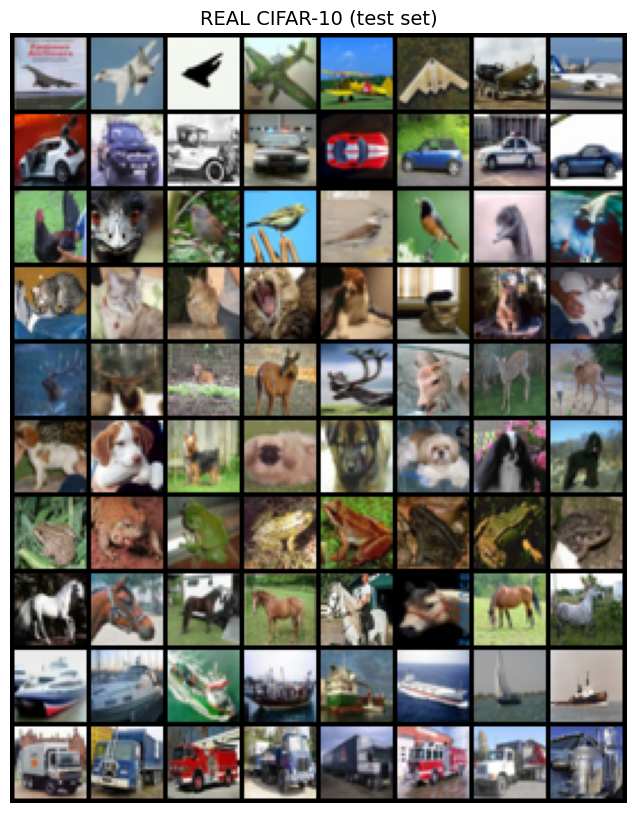

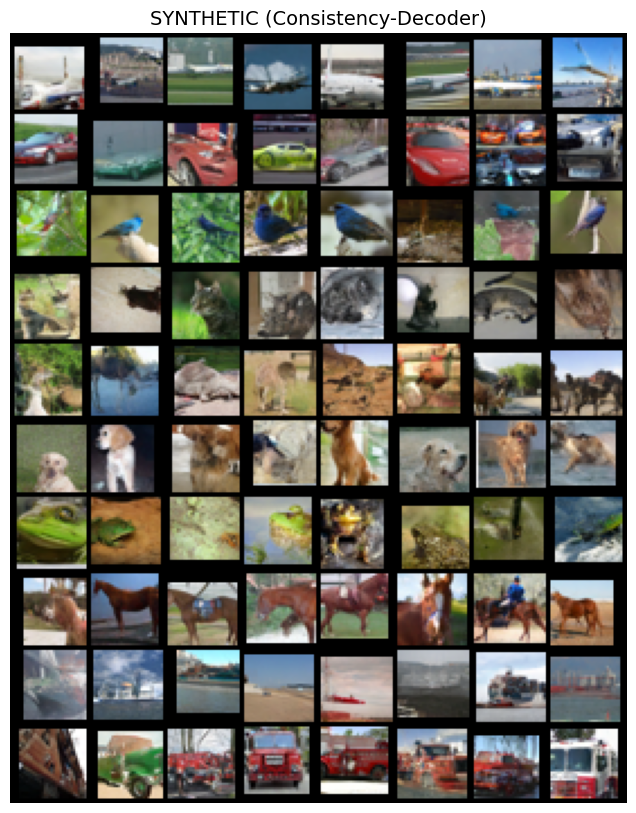

[   1/100] loss=2.389 acc= 9.44%  ε=1.62
[   2/100] loss=2.387 acc= 9.35%  ε=1.74
[   3/100] loss=2.359 acc= 9.46%  ε=1.83
[   4/100] loss=2.351 acc= 9.60%  ε=1.90
[   5/100] loss=2.353 acc= 9.82%  ε=1.96
[   6/100] loss=2.324 acc= 9.83%  ε=2.01
[   7/100] loss=2.336 acc= 9.72%  ε=2.06
[   8/100] loss=2.313 acc= 9.91%  ε=2.10
[   9/100] loss=2.319 acc=10.66%  ε=2.15
[  10/100] loss=2.307 acc=10.80%  ε=2.19
[  11/100] loss=2.301 acc=11.07%  ε=2.23
[  12/100] loss=2.298 acc=11.65%  ε=2.26
[  13/100] loss=2.311 acc=12.21%  ε=2.30
[  14/100] loss=2.303 acc=12.86%  ε=2.33
[  15/100] loss=2.297 acc=13.47%  ε=2.37
[  16/100] loss=2.306 acc=14.09%  ε=2.40
[  17/100] loss=2.302 acc=14.94%  ε=2.43
[  18/100] loss=2.292 acc=15.91%  ε=2.46
[  19/100] loss=2.293 acc=16.59%  ε=2.49
[  20/100] loss=2.283 acc=17.19%  ε=2.52
[  21/100] loss=2.267 acc=17.15%  ε=2.55
[  22/100] loss=2.265 acc=16.63%  ε=2.58
[  23/100] loss=2.258 acc=16.85%  ε=2.61
[  24/100] loss=2.265 acc=17.36%  ε=2.64
[  25/100] loss=

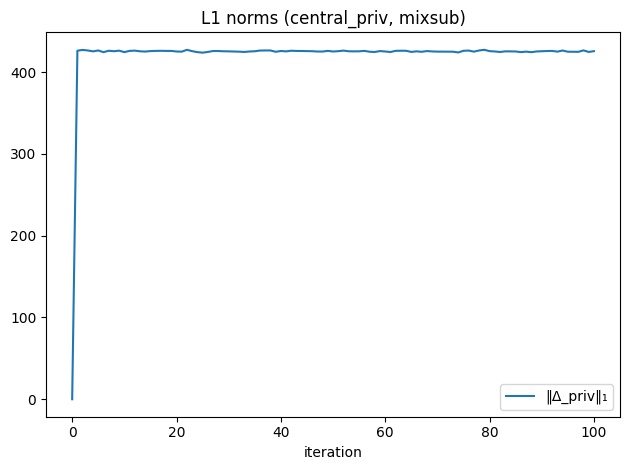

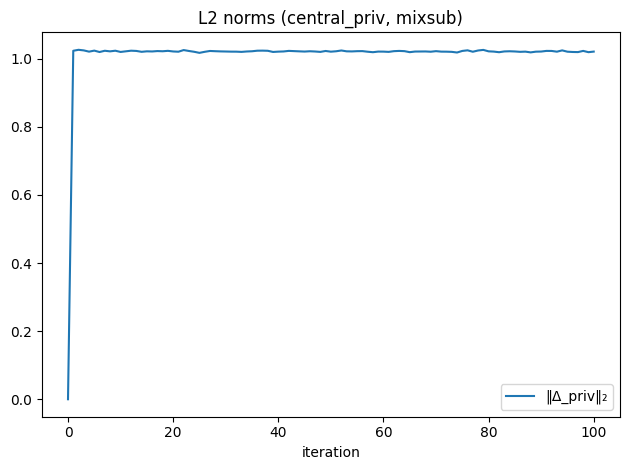

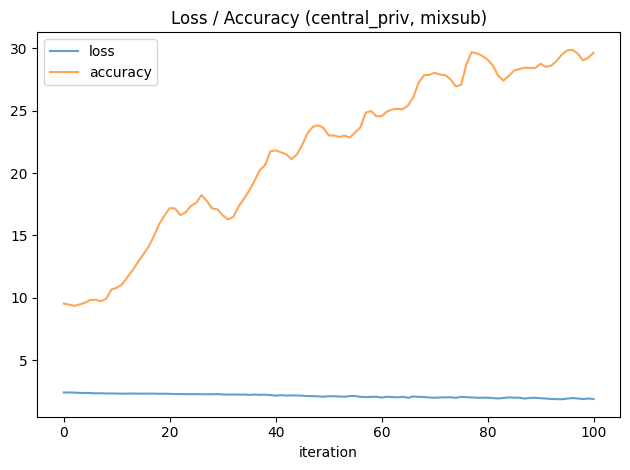

In [ ]:
#!/usr/bin/env python3
# ===============================================================
#  Unified DP vision benchmark – CIFAR‑10 (private) + synthetic (public)
#  ✦ PUBLIC_METHOD ∈ {"add", "mixsub"} controls how public gradients are used
#  (2025‑07‑10 bug‑fixed & instrumented edition)
# ===============================================================

import os, random, warnings, time
from itertools import cycle
from collections import defaultdict
import sys, torch, matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from opacus.validators import ModuleValidator
from opacus.accountants import RDPAccountant
from opacus.grad_sample import GradSampleModule
from diffusers import ConsistencyModelPipeline            # light decoder
import torchvision.transforms as T

warnings.filterwarnings("ignore", category=UserWarning)

# ------------------------------------------------------------------
# 0.  Flags & debug knob
# ------------------------------------------------------------------
EXPERIMENT      = os.getenv("EXPERIMENT", "central_priv")
PUBLIC_METHOD   = os.getenv("PUBLIC_METHOD", "mixsub").lower()     # add | mixsub
DEBUG           = bool(int(os.getenv("DEBUG", "1")))               # 0 = silent
FIXED_PUB = bool(int(os.getenv("FIXED_PUB", "0")))  # set 0 to keep dynamic

assert PUBLIC_METHOD in {"add", "mixsub"}, "PUBLIC_METHOD must be add|mixsub"

# ------------------------------------------------------------------
# 1.  Hyper‑parameters
# ------------------------------------------------------------------
SEED, PRIV_BATCH, PUB_BATCH = 0, 512, 500
NUM_EPOCHS, HEARTBEAT       = 5, 1

K_LOCAL, ETA_LOCAL          = 3, 0.025

# ---- learning‑rates -----------------------------------------------------------
LR_OUTER, MOMENTUM_OUTER    = 0.05, 0.9          # used by *central* DP‑SGD
OUTER_LR_LOCAL              = float(os.getenv("OUTER_LR_LOCAL", "1.0"))
OUTER_LR_SCAFFOLD           = float(os.getenv("OUTER_LR_SCAFFOLD", "1.0"))

# ---- clipping / noise ---------------------------------------------------------
C_CLIP_PRIV                 = 1.0                                      # private
C_CLIP_PUB                  = float(os.getenv("C_CLIP_PUB", "1.0"))    # public
NOISE_MULT                  = 1.0
DELTA                       = 1e-5

MILESTONES, GAMMA           = [10, 13], 0.1
DATA_FRACTION, SELF_AUG_FACTOR = 0.2, 1
DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

α_SCALE = PUB_BATCH / (PRIV_BATCH + PUB_BATCH)   # factor for mix‑subtract

# ------------------------------------------------------------------
# 2.  RNG
# ------------------------------------------------------------------
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)

# ------------------------------------------------------------------
# 3.  CIFAR-10  (⇐ no RandomErasing)
# ------------------------------------------------------------------
mean, std = [0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]

train_tf = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_tf = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar_train = datasets.CIFAR10("./data", train=True, download=True, transform=train_tf)
num_priv    = int(len(cifar_train) * DATA_FRACTION)
priv_idx    = np.random.choice(len(cifar_train), num_priv, replace=False)
priv_base   = Subset(cifar_train, priv_idx)

class IdxSubset(Subset):
    def __getitem__(self, i):
        x, y = super().__getitem__(i)
        return x, y, i

private_set = ConcatDataset([IdxSubset(priv_base, range(num_priv))] * SELF_AUG_FACTOR)
N_PRIVATE   = len(private_set)
train_priv  = DataLoader(private_set, PRIV_BATCH, shuffle=True,
                         num_workers=2, pin_memory=True)

# ------------------------------------------------------------------
# 4.  Synthetic image generator  (Consistency-Decoder ImageNet-64)
# ------------------------------------------------------------------
_IMAGENET_MAP = {0: 404, 1: 817, 2: 14, 3: 281, 4: 354,
                 5: 207, 6: 30, 7: 339, 8: 510, 9: 555}

def build_pipe():
    pipe = ConsistencyModelPipeline.from_pretrained(
        "openai/diffusers-cd_imagenet64_l2",
        torch_dtype=torch.float16
    ).to(DEVICE)
    pipe.set_progress_bar_config(disable=True)
    return pipe

class DiffusionBuffer:
    """
    On-the-fly synthetic CIFAR-sized images produced by Consistency Decoding.
    Guarantees that __next__ always returns exactly `bs` images.
    """
    def __init__(self, bs=PUB_BATCH, pool=128, steps=1, mb=16):
        self.bs     = bs
        self.pool   = max(pool, bs)          # <- ensure queue ≥ batch size
        self.steps  = steps
        self.mb     = mb
        self.pipe   = build_pipe()
        self.img_q  = torch.empty(0, 3, 32, 32)
        self.lab_q  = torch.empty(0, dtype=torch.long)
        self.resize = T.Resize(32, T.InterpolationMode.BICUBIC, antialias=True)
        self._refill()

    @torch.no_grad()
    def _refill(self):
        need = max(self.pool, self.bs) - self.img_q.size(0)
        if need <= 0:
            return                            # already have enough
        labels = torch.randint(0, 10, (need,))
        imgs   = []
        for i in range(0, need, self.mb):
            cls_ids = torch.tensor([_IMAGENET_MAP[int(c)]
                                    for c in labels[i:i + self.mb]], device=DEVICE)
            pil = self.pipe(batch_size=cls_ids.numel(),
                            class_labels=cls_ids,
                            num_inference_steps=self.steps).images
            imgs.extend(pil)

        # ---- defend against empty returns ------------------------------------
        if not imgs:
            raise RuntimeError("Diffusion pipeline returned 0 images. "
                               "Try reducing PUB_BATCH or check GPU memory.")

        tens = torch.stack([train_tf(self.resize(p)) for p in imgs])
        self.img_q = torch.cat([self.img_q, tens.cpu()])
        self.lab_q = torch.cat([self.lab_q, labels])

    def __iter__(self):
        return self

    def __next__(self):
        while self.img_q.size(0) < self.bs:   # keep refilling until enough
            self._refill()
        X, y = self.img_q[:self.bs], self.lab_q[:self.bs]
        self.img_q, self.lab_q = self.img_q[self.bs:], self.lab_q[self.bs:]
        return X.to(DEVICE), y.to(DEVICE)


train_pub = DiffusionBuffer()
# ------------------------------------------------------------------
# optional: use a *fixed* synthetic mini-batch (control-variate style)
# ------------------------------------------------------------------

if FIXED_PUB:
    print("[INFO] Using a single static public batch for every iteration")
    _X_fixed, _y_fixed = next(train_pub)             # grab once at start

    def _fixed_loader():
        while True:                                 # endless generator
            yield _X_fixed, _y_fixed

    get_pub_iter = lambda: _fixed_loader()          # returns generator
else:
    from itertools import cycle
    get_pub_iter = lambda: cycle(train_pub)         # original behaviour



# ------------------------------------------------------------------
# 5.  Test set
# ------------------------------------------------------------------
test_set    = datasets.CIFAR10("./data", train=False, download=True, transform=test_tf)
test_loader = DataLoader(test_set, 512, shuffle=False, num_workers=2, pin_memory=True)

# ------------------------------------------------------------------
# 6.  ResNet‑20  (GroupNorm+ELU)
# ------------------------------------------------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inp, outp, stride=1):
        super().__init__()
        self.c1 = nn.Conv2d(inp, outp, 3, stride, 1, bias=False)
        self.n1 = nn.GroupNorm(8, outp)
        self.c2 = nn.Conv2d(outp, outp, 3, 1, 1, bias=False)
        self.n2 = nn.GroupNorm(8, outp)
        self.sc = nn.Identity() if stride == 1 and inp == outp else \
                  nn.Sequential(nn.Conv2d(inp, outp, 1, stride, bias=False),
                                nn.GroupNorm(8, outp))
    def forward(self, x):
        out = self.n1(F.elu(self.c1(x)))
        out = self.n2(F.elu(self.c2(out)))
        return F.elu(out + self.sc(x))

class ResNet20(nn.Module):
    def __init__(self, classes=10):
        super().__init__()
        self.inp = 16
        self.c1  = nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.n1  = nn.GroupNorm(8, 16)
        self.l1  = self._layer(16, 3, 1)
        self.l2  = self._layer(32, 3, 2)
        self.l3  = self._layer(64, 3, 2)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(64, classes)
    def _layer(self, ch, blocks, stride):
        seq = []
        for s in [stride] + [1] * (blocks - 1):
            seq.append(BasicBlock(self.inp, ch, s))
            self.inp = ch
        return nn.Sequential(*seq)
    def forward(self, x):
        x = self.n1(F.elu(self.c1(x)))
        x = self.l1(x); x = self.l2(x); x = self.l3(x)
        return self.fc(torch.flatten(self.avg(x), 1))

def build_model():
    m = ResNet20().to(DEVICE)
    if ModuleValidator.validate(m, strict=False):
        m = ModuleValidator.fix(m).to(DEVICE)
    return m

# ------------------------------------------------------------------
# 7‑A.  Generic helpers
# ------------------------------------------------------------------
@torch.no_grad()
def flat(m): return torch.cat([p.data.view(-1) for p in m.parameters()])

@torch.no_grad()
def assign(m, vec):
    i = 0
    for p in m.parameters():
        n = p.numel()
        p.data.copy_(vec[i:i + n].view_as(p))
        i += n

@torch.no_grad()
def accuracy(m):
    m.eval(); tot = 0; cor = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            cor += (m(X).argmax(1) == y).sum().item()
            tot += y.size(0)
    m.train()
    return 100 * cor / tot

def l1(x): return x.norm(1).item()
def l2(x): return x.norm(2).item()
def cosine(a, b):
    if b is None or b.numel() == 0:
        return 0.0
    return F.cosine_similarity(a, b, dim=0, eps=1e-8).item()

def init_log(): return defaultdict(list)

def clip_agg(mat, c, add_noise=True):
    norms   = mat.norm(2, 1, keepdim=True)
    clipped = mat * torch.clamp(c / (norms + 1e-6), max=1.)
    vec     = clipped.mean(0)
    if add_noise:
        vec += torch.randn_like(vec) * (NOISE_MULT * c / mat.size(0))
    return vec, norms.squeeze(), (clipped != mat).any(1)

# ------------------------------------------------------------------
# 7-A-bis.  Safe live-debug printer
# ------------------------------------------------------------------
def dbg(step, Δp, Δq, upd, acc, eps):
    """
    Pretty-prints L2 norms, cosine, accuracy & ε every HEARTBEAT steps.
    Works even if Δq is None (no public data branch).
    """
    if not DEBUG or step % HEARTBEAT:
        return
    l2_q = l2(Δq) if Δq is not None else 0.0
    print(f"[{step:4}]  ‖Δp‖₂={l2(Δp):6.3f}  "
          f"‖Δq‖₂={l2_q:6.3f}  "
          f"cos={cosine(Δp, Δq):6.3f}  "
          f"‖upd‖₂={l2(upd):6.3f}  "
          f"acc={acc:5.2f}%  ε={eps:5.2f}", flush=True)


# ------------------------------------------------------------------
# 7‑B.  Baseline logging helper
# ------------------------------------------------------------------
@torch.no_grad()
def log_baseline(model, log, Xp, yp, Xq=None, yq=None):
    model.eval()
    loss_p = F.cross_entropy(model(Xp), yp).item()
    if Xq is not None:
        loss_q = F.cross_entropy(model(Xq), yq).item()
        log["loss"].append((loss_p + loss_q) / 2)
    else:
        log["loss"].append(loss_p)
    log["acc"].append(accuracy(model)); log["acc_step"].append(0)
    for k in ("l1_priv", "l2_priv", "l1_pub", "l2_pub", "cos"):
        log[k].append(0.0)
    model.train()

# ------------------------------------------------------------------
# 7‑C.  Plotter (unchanged)
# ------------------------------------------------------------------
def plot_curves(log, title_suffix=""):
    its = list(range(len(log["loss"])))
    plt.figure()
    plt.plot(its, log["l1_priv"], label="‖Δ_priv‖₁")
    if any(log["l1_pub"]): plt.plot(its, log["l1_pub"], label="‖Δ_pub‖₁")
    plt.title("L1 norms" + title_suffix); plt.xlabel("iteration"); plt.legend(); plt.tight_layout()

    plt.figure()
    plt.plot(its, log["l2_priv"], label="‖Δ_priv‖₂")
    if any(log["l2_pub"]): plt.plot(its, log["l2_pub"], label="‖Δ_pub‖₂")
    plt.title("L2 norms" + title_suffix); plt.xlabel("iteration"); plt.legend(); plt.tight_layout()

    if any(log["cos"]):
        plt.figure()
        plt.plot(its, log["cos"])
        plt.title("Cosine(Δ_priv, Δ_pub)" + title_suffix)
        plt.xlabel("iteration"); plt.tight_layout()

    plt.figure()
    plt.plot(its, log["loss"], label="loss", alpha=0.7)
    if log["acc"]:
        plt.plot(log["acc_step"], log["acc"], label="accuracy", alpha=0.7)
    plt.title("Loss / Accuracy" + title_suffix); plt.xlabel("iteration"); plt.legend(); plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 8‑A. CENTRAL DP‑SGD  (minor: use new clip consts for clarity)
# ------------------------------------------------------------------
def train_central(use_public: bool):
    model = GradSampleModule(build_model())
    opt   = optim.SGD(model.parameters(), lr=LR_OUTER, momentum=MOMENTUM_OUTER)
    sched = optim.lr_scheduler.MultiStepLR(opt, MILESTONES, GAMMA)
    accnt, sr = RDPAccountant(), PRIV_BATCH / N_PRIVATE
    pub_iter = get_pub_iter() if use_public else None

    log, step, total = init_log(), 0, NUM_EPOCHS * len(train_priv)
    log["acc_step"] = []

    # ---- baseline -------------------------------------------------------------
    X0p, y0p, _ = next(iter(train_priv)); X0p, y0p = X0p.to(DEVICE), y0p.to(DEVICE)
    if use_public:
        X0q, y0q = next(iter(train_pub))
    else:
        X0q = y0q = None
    log_baseline(model, log, X0p, y0p, X0q, y0q)

    for epoch in range(NUM_EPOCHS):
        for Xp, yp, _ in train_priv:
            step += 1
            Xp, yp = Xp.to(DEVICE), yp.to(DEVICE)

            # ---- PRIVATE pass --------------------------------------------------
            opt.zero_grad(set_to_none=True)
            loss = F.cross_entropy(model(Xp), yp)
            loss.backward()
            log["loss"].append(loss.item())

            priv_norms = []
            for p in model.parameters():
                priv_norms.append(p.grad_sample.pow(2).flatten(1).sum(1))
            priv_norms = torch.stack(priv_norms).sum(0).sqrt()
            scale = (C_CLIP_PRIV / (priv_norms + 1e-6)).clamp(max=1.)
            for p in model.parameters():
                p.grad = (p.grad_sample * scale.view(-1, *([1] * (p.grad_sample.dim() - 1)))).sum(0)
                p.grad /= PRIV_BATCH
                p.grad += torch.randn_like(p.grad) * (NOISE_MULT * C_CLIP_PRIV / PRIV_BATCH)
                p.grad_sample = None
            delta_priv = torch.cat([p.grad.flatten() for p in model.parameters()])
            log["l1_priv"].append(l1(delta_priv)); log["l2_priv"].append(l2(delta_priv))

            if use_public:
                # ---- PUBLIC pass ----------------------------------------------
                opt.zero_grad(set_to_none=True)
                Xq, yq = next(pub_iter)
                F.cross_entropy(model(Xq), yq).backward()

                pub_norms = []
                for p in model.parameters():
                    pub_norms.append(p.grad_sample.pow(2).flatten(1).sum(1))
                pub_norms = torch.stack(pub_norms).sum(0).sqrt()
                scale_pub = (C_CLIP_PUB / (pub_norms + 1e-6)).clamp(max=1.)
                for p in model.parameters():
                    p.grad = (p.grad_sample *
                              scale_pub.view(-1, *([1] * (p.grad_sample.dim() - 1)))).sum(0)
                    p.grad /= PUB_BATCH
                    p.grad_sample = None
                delta_pub = torch.cat([p.grad.flatten() for p in model.parameters()])
                log["l1_pub"].append(l1(delta_pub)); log["l2_pub"].append(l2(delta_pub))
                log["cos"].append(cosine(delta_priv, delta_pub))
            else:
                delta_pub = torch.zeros_like(delta_priv)
                log["l1_pub"].append(0.0); log["l2_pub"].append(0.0); log["cos"].append(0.0)

            # ---- Combine -------------------------------------------------------
            if   not use_public:          update = delta_priv
            elif PUBLIC_METHOD == "add":  update = delta_priv + delta_pub
            else:                         update = delta_priv - α_SCALE * delta_pub

            with torch.no_grad():
                splits = torch.split(update, [p.numel() for p in model.parameters()])
                for p, u in zip(model.parameters(), splits):
                    p.grad = u.view_as(p)
            opt.step()
            accnt.step(noise_multiplier=NOISE_MULT, sample_rate=sr)

            if step % HEARTBEAT == 0:
                acc = accuracy(model)
                log["acc"].append(acc); log["acc_step"].append(step)
                print(f"[{step:>4}/{total}] loss={loss.item():.3f} "
                      f"acc={acc:5.2f}%  ε={accnt.get_epsilon(DELTA):.2f}")

        sched.step()
    summary(model, accnt, log, "central_" + ("pub" if use_public else "priv"))

# ------------------------------------------------------------------
# 8‑B. Helper for LOCAL DP‑SGD
# ------------------------------------------------------------------
def local_updates(global_model, X, y):
    base = flat(global_model).clone()
    deltas = []
    for j in range(X.size(0)):
        local = build_model(); assign(local, base)
        opt = optim.SGD(local.parameters(), lr=ETA_LOCAL)
        for _ in range(K_LOCAL):
            opt.zero_grad(set_to_none=True)
            F.cross_entropy(local(X[j:j + 1]), y[j:j + 1]).backward()
            opt.step()
        deltas.append(flat(local) - base)
        del local
    return torch.stack(deltas, 0)    # shape: [|X|, |θ|]

# ------------------------------------------------------------------
# 8‑B.  LOCAL DP‑SGD  (fixed & instrumented)
# ------------------------------------------------------------------
def train_local(use_public: bool):
    model = build_model()

    dummy_sched = optim.lr_scheduler.MultiStepLR(
        optim.SGD(model.parameters(), lr=0.01), MILESTONES, GAMMA
    )

    accnt, sr   = RDPAccountant(), PRIV_BATCH / N_PRIVATE
    pub_iter = get_pub_iter() if use_public else None

    log, step   = init_log(), 0
    total       = NUM_EPOCHS * len(train_priv)
    log["acc_step"] = []

    # ---- baseline -------------------------------------------------------------
    X0p, y0p, _ = next(iter(train_priv)); X0p, y0p = X0p.to(DEVICE), y0p.to(DEVICE)
    if use_public:
        X0q, y0q = next(iter(train_pub))
    else:
        X0q = y0q = None
    log_baseline(model, log, X0p, y0p, X0q, y0q)

    for epoch in range(NUM_EPOCHS):
        for Xp, yp, _ in train_priv:
            step += 1
            Xp, yp = Xp.to(DEVICE), yp.to(DEVICE)
            n_priv = Xp.size(0)

            if use_public:
                Xq, yq = next(pub_iter); Xq, yq = Xq.to(DEVICE), yq.to(DEVICE)
                X = torch.cat([Xp, Xq]); y = torch.cat([yp, yq])
            else:
                X, y = Xp, yp

            # ---- local client updates (no clip/noise yet) ----------------------
            deltas = local_updates(model, X, y)

            if use_public:
                delta_priv, delta_pub = deltas[:n_priv], deltas[n_priv:]
            else:
                delta_priv, delta_pub = deltas, None

            Δp_bar, _, _ = clip_agg(delta_priv, C_CLIP_PRIV, add_noise=True)
            if delta_pub is not None and delta_pub.numel():
                Δq_bar, _, _ = clip_agg(delta_pub, C_CLIP_PUB, add_noise=False)
            else:
                Δq_bar = torch.zeros_like(Δp_bar)

            # ---- mix private & public -----------------------------------------
            if   not use_public:          update = Δp_bar
            elif PUBLIC_METHOD == "add":  update = Δp_bar + Δq_bar
            else:                         update = Δp_bar - α_SCALE * Δq_bar

            # ---- outer update (no extra shrink) -------------------------------
            assign(model, flat(model) + OUTER_LR_LOCAL * update.to(DEVICE))

            # ---- bookkeeping & debug ------------------------------------------
            log["l1_priv"].append(l1(Δp_bar)); log["l2_priv"].append(l2(Δp_bar))
            log["l1_pub"].append(l1(Δq_bar));  log["l2_pub"].append(l2(Δq_bar))
            log["cos"].append(cosine(Δp_bar, Δq_bar) if use_public else 0.0)
            log["loss"].append(F.cross_entropy(model(Xp), yp).item())
            accnt.step(noise_multiplier=NOISE_MULT, sample_rate=sr)

            if step % HEARTBEAT == 0:
                acc = accuracy(model)
                log["acc"].append(acc); log["acc_step"].append(step)
                dbg(step, Δp_bar, Δq_bar if use_public else None,
                    update, acc, accnt.get_epsilon(DELTA))

        dummy_sched.step()

    summary(model, accnt, log, "local_" + ("pub" if use_public else "priv"))

# ------------------------------------------------------------------
# 8‑C. DP‑SCAFFOLD
# ------------------------------------------------------------------
class DPScaffold:
    def __init__(self, model):
        self.vg = torch.zeros_like(flat(model), device=DEVICE)
        self.vc = {c: torch.zeros_like(flat(model), device=DEVICE) for c in range(10)}

    def local_step(self, model, X, y):
        base = flat(model).clone()
        outs = []
        for j in range(X.size(0)):
            loc = build_model(); assign(loc, base)
            opt = optim.SGD(loc.parameters(), lr=ETA_LOCAL)
            vc  = self.vc[int(y[j])]
            for _ in range(K_LOCAL):
                opt.zero_grad(set_to_none=True)
                preds = loc(X[j:j + 1])
                loss  = F.cross_entropy(preds, y[j:j + 1])
                grads = torch.autograd.grad(loss, loc.parameters())
                gvec  = torch.cat([g.view(-1) for g in grads])
                gvec  = gvec - vc.detach() + self.vg.detach()
                with torch.no_grad():
                    assign(loc, flat(loc) - ETA_LOCAL * gvec)
            outs.append(flat(loc) - base); del loc
        return torch.stack(outs, 0)

    def update_control(self, δ, y):
        for c in range(10):
            m = (y.cpu() == c)
            if m.any():
                self.vc[c] = self.vc[c] - self.vg + δ[m].mean(0) / (K_LOCAL * ETA_LOCAL)
        self.vg = self.vg * (1 - PRIV_BATCH / N_PRIVATE) + δ.mean(0) / (K_LOCAL * ETA_LOCAL)

# ------------------------------------------------------------------
# 8‑C.  DP‑SCAFFOLD (fixed & instrumented)
# ------------------------------------------------------------------
def train_scaffold(use_public: bool):
    model = build_model()
    scaf  = DPScaffold(model)

    dummy_opt = optim.SGD(model.parameters(), lr=1.0)   # LR unused
    sched     = optim.lr_scheduler.MultiStepLR(dummy_opt, MILESTONES, GAMMA)

    accnt, sr = RDPAccountant(), PRIV_BATCH / N_PRIVATE
    pub_iter = get_pub_iter() if use_public else None

    log, step = init_log(), 0
    total     = NUM_EPOCHS * len(train_priv)
    log["acc_step"] = []

    # ---- baseline -------------------------------------------------------------
    X0p, y0p, _ = next(iter(train_priv)); X0p, y0p = X0p.to(DEVICE), y0p.to(DEVICE)
    if use_public:
        X0q, y0q = next(iter(train_pub))
    else:
        X0q = y0q = None
    log_baseline(model, log, X0p, y0p, X0q, y0q)

    for epoch in range(NUM_EPOCHS):
        for Xp, yp, _ in train_priv:
            step += 1
            Xp, yp = Xp.to(DEVICE), yp.to(DEVICE)
            n_priv = Xp.size(0)

            if use_public:
                Xq, yq = next(pub_iter); Xq, yq = Xq.to(DEVICE), yq.to(DEVICE)
                X = torch.cat([Xp, Xq]); y = torch.cat([yp, yq])
            else:
                X, y = Xp, yp

            # ---- local client updates with control variates --------------------
            local_tmp = build_model(); assign(local_tmp, flat(model))
            deltas    = scaf.local_step(local_tmp, X, y)
            del local_tmp

            δp, δq = (deltas[:n_priv], deltas[n_priv:]) if use_public else (deltas, None)

            Δp_bar, _, _ = clip_agg(δp, C_CLIP_PRIV, add_noise=True)
            if use_public and δq.numel():
                Δq_bar, _, _ = clip_agg(δq, C_CLIP_PUB, add_noise=False)
            else:
                Δq_bar = torch.zeros_like(Δp_bar)

            # ---- fuse ----------------------------------------------------------
            if   not use_public:          Δbar = Δp_bar
            elif PUBLIC_METHOD == "add":  Δbar = Δp_bar + Δq_bar
            else:                         Δbar = Δp_bar - α_SCALE * Δq_bar

            # ---- global update without extra shrink ---------------------------
            assign(model, flat(model) + OUTER_LR_SCAFFOLD * Δbar.to(DEVICE))

            # ---- update control variates (private only) ------------------------
            scaf.update_control(δp.to(DEVICE), yp)

            # ---- bookkeeping & debug ------------------------------------------
            log["l1_priv"].append(l1(Δp_bar)); log["l2_priv"].append(l2(Δp_bar))
            log["l1_pub"].append(l1(Δq_bar));  log["l2_pub"].append(l2(Δq_bar))
            log["cos"].append(cosine(Δp_bar, Δq_bar) if use_public else 0.0)
            log["loss"].append(F.cross_entropy(model(Xp), yp).item())
            accnt.step(noise_multiplier=NOISE_MULT, sample_rate=sr)

            if step % HEARTBEAT == 0:
                acc = accuracy(model)
                log["acc"].append(acc); log["acc_step"].append(step)
                dbg(step, Δp_bar, Δq_bar if use_public else None,
                    Δbar, acc, accnt.get_epsilon(DELTA))

        sched.step()

    summary(model, accnt, log, "scaffold_" + ("pub" if use_public else "priv"))

# ------------------------------------------------------------------
# 9.  Summary + plots
# ------------------------------------------------------------------
def summary(model, accnt, log, name):
    print(f"\n{name}: final acc={accuracy(model):.2f}%  "
          f"ε={accnt.get_epsilon(DELTA):.2f}")
    plot_curves(log, f" ({name}, {PUBLIC_METHOD})")

# ------------------------------------------------------------------
# 10.  Dispatcher
# ------------------------------------------------------------------
if __name__ == "__main__":
    print(f"Experiment: {EXPERIMENT} • PUBLIC_METHOD={PUBLIC_METHOD} "
          f"• DEBUG={'on' if DEBUG else 'off'}")
    print(f"Private data : {N_PRIVATE} CIFAR‑10 images")
    print(f"Public batch : {PUB_BATCH} synthetic samples\n")

    SAMPLES_PER_CLASS = int(os.getenv("N_SHOW", "8"))   # one row length

    # -----------------------------------------------------------
    # helper to un-normalise tensors back to RGB [0,1]
    # -----------------------------------------------------------
    def denorm(batch, mean=mean, std=std):
        m = torch.tensor(mean, device=batch.device).view(3, 1, 1)
        s = torch.tensor(std , device=batch.device).view(3, 1, 1)
        return (batch * s + m).clamp(0, 1)

    # -----------------------------------------------------------
    # collect synthetic samples from the diffusion buffer
    # -----------------------------------------------------------
    synth_by_class = {c: [] for c in range(10)}
    with torch.no_grad():
        while min(len(v) for v in synth_by_class.values()) < SAMPLES_PER_CLASS:
            Xs, ys = next(train_pub)        # iterator already on DEVICE
            for x, y in zip(Xs, ys):
                if len(synth_by_class[int(y)]) < SAMPLES_PER_CLASS:
                    synth_by_class[int(y)].append(x.cpu())

    # -----------------------------------------------------------
    # collect real CIFAR-10 test images
    # -----------------------------------------------------------
    real_by_class = {c: [] for c in range(10)}
    for img, lab in test_set:
        if len(real_by_class[lab]) < SAMPLES_PER_CLASS:
            real_by_class[lab].append(img)
        if min(len(v) for v in real_by_class.values()) == SAMPLES_PER_CLASS:
            break

    # -----------------------------------------------------------
    # visualise
    # -----------------------------------------------------------
    def show_grid(by_class_dict, title):
        rows = []
        for c in range(10):
            row = torch.stack(by_class_dict[c], 0)           # (N,3,32,32)
            rows.append(denorm(row))
        grid = make_grid(torch.cat(rows, 0),
                         nrow=SAMPLES_PER_CLASS,
                         padding=2).permute(1, 2, 0).numpy()
        plt.figure(figsize=(SAMPLES_PER_CLASS, 10))
        plt.imshow(grid)
        plt.axis("off")
        plt.title(title, fontsize=14)
        plt.show()

    show_grid(real_by_class,   "REAL CIFAR-10 (test set)")
    show_grid(synth_by_class,  "SYNTHETIC (Consistency-Decoder)")


    if   EXPERIMENT == "central_priv":   train_central(False)
    elif EXPERIMENT == "central_pub":    train_central(True)
    elif EXPERIMENT == "local_priv":     train_local(False)
    elif EXPERIMENT == "local_pub":      train_local(True)
    elif EXPERIMENT == "scaffold_priv":  train_scaffold(False)
    elif EXPERIMENT == "scaffold_pub":   train_scaffold(True)
    else: raise ValueError("Unknown EXPERIMENT")
